In [17]:
%run utils.ipynb
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime

pd.set_option('max.columns', None)
import tqdm

In [2]:
df_raw = pd.read_csv('../data/clean_union_exploration_04_29_20_22_00.csv')
df_raw.shape

(19871, 13)

In [3]:
df_raw

,id,box_id,device_type,false_character,hold_for,key_pressed,location,long_pressed_equivalent,name,platform,pressed_after,timestamp,user_id
0,17952,#text-area-1,Computer/Laptop,f,209,Shift,16,2,Varun Sapre,Win32,0,1586594740199,610281f4-7233-4cd1-8a8f-308b1c333267
1,17953,#text-area-1,Computer/Laptop,f,24,t,84,1,Varun Sapre,Win32,78,1586594740487,610281f4-7233-4cd1-8a8f-308b1c333267
2,17954,#text-area-1,Computer/Laptop,f,64,h,72,1,Varun Sapre,Win32,80,1586594740591,610281f4-7233-4cd1-8a8f-308b1c333267
3,17955,#text-area-1,Computer/Laptop,f,33,i,73,1,Varun Sapre,Win32,23,1586594740678,610281f4-7233-4cd1-8a8f-308b1c333267
4,17956,#text-area-1,Computer/Laptop,f,106,,32,1,Varun Sapre,Win32,127,1586594740838,610281f4-7233-4cd1-8a8f-308b1c333267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19866,17942,#text-area-test,Computer/Laptop,t,72,Backspace,8,1,Jimmy Francis Basil,Win32,86,1586369696970,84f45f69-87fa-454b-bb5e-ac989fde8a38
19867,17943,#text-area-test,Computer/Laptop,t,71,g,71,1,Jimmy Francis Basil,Win32,524,1586369697566,84f45f69-87fa-454b-bb5e-ac989fde8a38
19868,17944,#text-area-test,Computer/Laptop,t,63,r,82,1,Jimmy Francis Basil,Win32,183,1586369697820,84f45f69-87fa-454b-bb5e-ac989fde8a38
19869,17945,#text-area-test,Computer/Laptop,t,79,a,65,1,Jimmy Francis Basil,Win32,109,1586369697992,84f45f69-87fa-454b-bb5e-ac989fde8a38


In [4]:
df_raw.loc[(df_raw['device_type'] == 'Computer/Laptop') & (df_raw['platform'] == 'iPhone'), 'platform'] = 'MacIntel'

In [5]:
df_raw['platform'].value_counts()

Win32       10395
MacIntel     6076
iPhone       3400
Name: platform, dtype: int64

In [6]:
earliest = datetime.fromtimestamp(df_raw.timestamp.min()/1000.0)
latest = datetime.fromtimestamp(df_raw.timestamp.max()/1000.0)
print(f"Collected {len(df_raw.name.unique())} users over {(latest-earliest).days} days")

Collected 21 users over 27 days


## Clean Exploration

In [7]:
def user_box_summary(df):
    """
        At a box level, derive user summary.
            - characters captured, true vs false, percentages
            - time spent on box, true vs false, percentages
            - hold_for & pressed_after --> averages, true vs false
    """
    user_summary = []
    box_cols = ['box_num','characters_cpatured','true_character_count','false_character_count','true_character_perc','false_character_perc',
               'time_spent_total','time_spent_true','time_spent_false','time_spent_true_perc','time_spent_false_perc',
               'hold_for_mean','hold_for_mean_true_characters','hold_for_mean_falase_characters',
                'pressed_after_mean','pressed_after_mean_true_characters','pressed_after_mean_false_characters']
    columns = ['name','device_type','platform'] + box_cols
    
    for user in tqdm.tqdm(df.name.unique()):
        user_row = [user]
        u_df = df[df['name'] == user]
        user_row.extend([u_df['device_type'].unique()[0], u_df['platform'].unique()[0]])
        
        for i,box in enumerate(df['box_id'].unique().tolist()):
            user_box_row = user_row.copy()
            u_b_df = u_df[u_df['box_id'] == box]
            true_df = u_b_df[u_b_df['false_character'] == 'f']
            false_df = u_b_df[u_b_df['false_character'] == 't']
            
            chars_captured = u_b_df['long_pressed_equivalent'].sum()
            true_chars_captured = true_df['long_pressed_equivalent'].sum()
            false_chars_captured = false_df['long_pressed_equivalent'].sum()
            
            time_spent = np.sum(u_b_df['hold_for'] + u_b_df['pressed_after'])
            time_spent_true = np.sum(true_df['hold_for'] + true_df['pressed_after'])
            time_spent_false = np.sum(false_df['hold_for'] + false_df['pressed_after'])
            
            
            
            user_box_row.extend([i+1, u_b_df['long_pressed_equivalent'].sum(),
                                true_chars_captured, false_chars_captured,
                                (true_chars_captured/chars_captured)*100,
                                (false_chars_captured/chars_captured)*100,
                                time_spent, time_spent_true, time_spent_false,
                                (time_spent_true/time_spent)*100, (time_spent_false/time_spent)*100,
                                 u_b_df['hold_for'].mean(),
                                 true_df['hold_for'].mean(),
                                 false_df['hold_for'].mean(),
                                 u_b_df['pressed_after'].mean(),
                                 true_df['pressed_after'].mean(),
                                 false_df['pressed_after'].mean()
                                ])
#             print(user_box_row, len(user_box_row), len(columns))
            user_summary.append(user_box_row)
    return pd.DataFrame(user_summary, columns=columns).round(2)

def user_summary(df):
    """
        At a high level, derive the characteristics of a user split by `TRUE_CHAR` and `FALSE_CHAR`.
        Total characters captured, time spent and respective percentages.
    """
    user_summary = []    
    columns = ['name','device_type','platform','type','total_characters','total_time_spent','character_perc','character_time_perc']

    for user in tqdm.tqdm(df.name.unique()):
        user_row = [user]
        u_df = df[df['name'] == user]
        
        user_row = [user, u_df['device_type'].unique()[0], u_df['platform'].unique()[0]]
        
        true_df = u_df[u_df['false_character'] == 'f']
        false_df = u_df[u_df['false_character'] == 't']

        chars_captured = u_df['long_pressed_equivalent'].sum()
        true_chars_captured = true_df['long_pressed_equivalent'].sum()
        false_chars_captured = false_df['long_pressed_equivalent'].sum()

        time_spent = np.sum(u_df['hold_for'] + u_df['pressed_after'])
        time_spent_true = np.sum(true_df['hold_for'] + true_df['pressed_after'])
        time_spent_false = np.sum(false_df['hold_for'] + false_df['pressed_after'])
        
        row = user_row.copy()
        row.extend(['TRUE_CHAR',true_chars_captured, time_spent_true,
                   (true_chars_captured/chars_captured)*100,
                   (time_spent_true/time_spent)*100])
        
        user_summary.append(row)
        row = user_row.copy()
        row.extend(['FALSE_CHAR',false_chars_captured, time_spent_false,
                   (false_chars_captured/chars_captured)*100,
                   (time_spent_false/time_spent)*100])
        user_summary.append(row)
    
    return pd.DataFrame(user_summary, columns=columns)
    

In [8]:
raw = df_raw
raw = raw[raw['long_pressed_equivalent'] < 3]

In [9]:
user_agg_test = user_summary(raw)
user_agg_test.head(12)

100%|██████████| 21/21 [00:00<00:00, 126.84it/s]


,name,device_type,platform,type,total_characters,total_time_spent,character_perc,character_time_perc
0,Varun Sapre,Computer/Laptop,Win32,TRUE_CHAR,1264,274736,64.227642,60.738762
1,Varun Sapre,Computer/Laptop,Win32,FALSE_CHAR,704,177588,35.772358,39.261238
2,Angilat,Computer/Laptop,Win32,TRUE_CHAR,268,78717,31.090487,29.495058
3,Angilat,Computer/Laptop,Win32,FALSE_CHAR,594,188165,68.909513,70.504942
4,Halimat,Computer/Laptop,Win32,TRUE_CHAR,810,425391,95.631641,97.784066
5,Halimat,Computer/Laptop,Win32,FALSE_CHAR,37,9640,4.368359,2.215934
6,Lola J,Computer/Laptop,Win32,TRUE_CHAR,203,149061,17.188823,37.349473
7,Lola J,Computer/Laptop,Win32,FALSE_CHAR,978,250037,82.811177,62.650527
8,Bunmi,Mobile/Tab,iPhone,TRUE_CHAR,570,186856,85.972851,84.740413
9,Bunmi,Mobile/Tab,iPhone,FALSE_CHAR,93,33648,14.027149,15.259587


In [10]:
user_agg_test.groupby('type').describe()

total_characters                                              \
                      count        mean         std   min    25%    50%   
type                                                                      
FALSE_CHAR             21.0  357.095238  358.645076  30.0   66.0  172.0   
TRUE_CHAR              21.0  680.238095  375.078912   0.0  553.0  714.0   

                          total_time_spent                                \
              75%     max            count           mean            std   
type                                                                       
FALSE_CHAR  544.0  1118.0             21.0  163860.857143  199497.979002   
TRUE_CHAR   846.0  1582.0             21.0  232314.142857  159787.482728   

                                                           character_perc  \
               min       25%       50%       75%       max          count   
type                                                                        
FALSE_CHAR  9226.0   25616.0   50022.0  250037.0  696802.0           21.0   
TRUE_CHAR      0.0  166354.0  186856.0  274736.0  680963.0           21.0   

                                                                        \
                 mean        std       min        25%   50%        75%   
type                                                                     
FALSE_CHAR  32.888497  31.959592  3.359462   7.482993  17.2  49.589790   
TRUE_CHAR   67.111503  31.959592  0.000000  50.410210  82.8  92.517007   

                       character_time_perc                                  \
                   max               count       mean        std       min   
type                                                                         
FALSE_CHAR  100.000000                21.0  33.854978  32.516623  2.215934   
TRUE_CHAR    96.640538                21.0  66.145022  32.516623  0.000000   

                                                         
                  25%        50%        75%         max  
type                                                     
FALSE_CHAR  10.032181  17.752777  62.650527  100.000000  
TRUE_CHAR   37.349473  82.247223  89.967819   97.784066

In [11]:
user_agg_test.groupby('type').describe()['character_perc']['mean']

type
FALSE_CHAR    32.888497
TRUE_CHAR     67.111503
Name: mean, dtype: float64

In [12]:
invalid_users = user_agg_test[(user_agg_test['type'] == 'TRUE_CHAR') & (user_agg_test['character_perc'] < 55)]
valid_users = user_agg_test[(user_agg_test['type'] == 'TRUE_CHAR') & (user_agg_test['character_perc'] >= 55)]
user_agg_test[(user_agg_test['type'] == 'TRUE_CHAR')]['character_perc'].mean(),invalid_users['character_perc'].mean(), valid_users['character_perc'].mean()
              

(67.11150334491215, 22.733544118331196, 84.86268703554452)

**NOTE** : It can be clearly seen that there lies some anamolous data where users have typed, on an average more `false_characters` than `true_characters`. Diving deeper, it can be seen that multiple text boxes for a user have < 10% `true_characters` primarily due the fact that somewhere in the beginning a user has typed an incorrect word and not cleared the mistake.


In [13]:
raw_clean = raw[raw['name'].isin(valid_users['name'].unique())]
raw.shape, raw_clean.shape


((19819, 13), (14063, 13))

In [14]:
raw_clean['long_pressed_equivalent'].value_counts()

1    12493
2     1570
Name: long_pressed_equivalent, dtype: int64

In [15]:
agg = {
    'hold_for' : np.sum,
    'pressed_after' : np.sum,
    'long_pressed_equivalent' : np.sum,

}
user_high_level = raw_clean.groupby(['name', 'platform']).agg(agg).reset_index()
user_high_level['total_time_spent'] = user_high_level['hold_for'] + user_high_level['pressed_after']
user_high_level

,name,platform,hold_for,pressed_after,long_pressed_equivalent,total_time_spent
0,Abdi Mohamud,MacIntel,85323,114484,966,199807
1,Adesola Ajisafe,iPhone,14651,257756,735,272407
2,Bunmi,iPhone,16159,204345,663,220504
3,Goddess,Win32,98715,253684,921,352399
4,Halimat,Win32,75774,359257,847,435031
5,Jonathan Ojapa,iPhone,21957,669901,1237,691858
6,Joshua Ojapa,iPhone,16606,265164,785,281770
7,Kedar,MacIntel,74555,108090,948,182645
8,Kunal Sonar,MacIntel,83298,150183,893,233481
9,Pop Eyes,Win32,98468,166831,900,265299


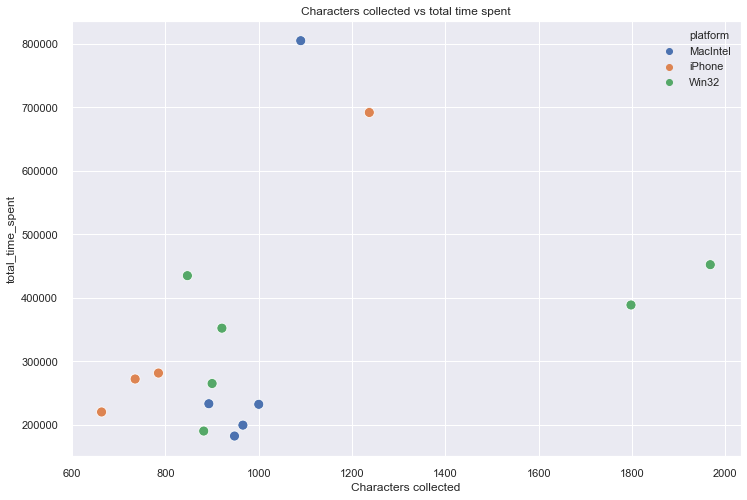

In [43]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='long_pressed_equivalent', y='total_time_spent', hue='platform', data=user_high_level, s=100)
plt.xlabel('Characters collected')
plt.title('Characters collected vs total time spent')
plt.savefig('../images/chars_vs_time.png', bbox_inches='tight')

In [19]:
user_agg = user_summary(raw_clean)
user_agg

100%|██████████| 15/15 [00:00<00:00, 127.84it/s]


,name,device_type,platform,type,total_characters,total_time_spent,character_perc,character_time_perc
0,Varun Sapre,Computer/Laptop,Win32,TRUE_CHAR,1264,274736,64.227642,60.738762
1,Varun Sapre,Computer/Laptop,Win32,FALSE_CHAR,704,177588,35.772358,39.261238
2,Halimat,Computer/Laptop,Win32,TRUE_CHAR,810,425391,95.631641,97.784066
3,Halimat,Computer/Laptop,Win32,FALSE_CHAR,37,9640,4.368359,2.215934
4,Bunmi,Mobile/Tab,iPhone,TRUE_CHAR,570,186856,85.972851,84.740413
5,Bunmi,Mobile/Tab,iPhone,FALSE_CHAR,93,33648,14.027149,15.259587
6,Goddess,Computer/Laptop,Win32,TRUE_CHAR,846,310439,91.856678,88.093042
7,Goddess,Computer/Laptop,Win32,FALSE_CHAR,75,41960,8.143322,11.906958
8,Abdi Mohamud,Computer/Laptop,MacIntel,TRUE_CHAR,878,179762,90.890269,89.967819
9,Abdi Mohamud,Computer/Laptop,MacIntel,FALSE_CHAR,88,20045,9.109731,10.032181


In [20]:
len(user_agg.name.unique())

15

In [21]:
user_box_agg = user_box_summary(raw_clean)
user_box_agg.head(12)

100%|██████████| 15/15 [00:00<00:00, 45.41it/s]


,name,device_type,platform,box_num,characters_cpatured,true_character_count,false_character_count,true_character_perc,false_character_perc,time_spent_total,time_spent_true,time_spent_false,time_spent_true_perc,time_spent_false_perc,hold_for_mean,hold_for_mean_true_characters,hold_for_mean_falase_characters,pressed_after_mean,pressed_after_mean_true_characters,pressed_after_mean_false_characters
0,Varun Sapre,Computer/Laptop,Win32,1,876,442,434,50.46,49.54,211996,107766,104230,50.83,49.17,100.80,99.93,101.69,195.28,197.77,192.74
1,Varun Sapre,Computer/Laptop,Win32,2,418,352,66,84.21,15.79,84756,67630,17126,79.79,20.21,99.86,100.32,97.53,134.27,123.62,187.90
2,Varun Sapre,Computer/Laptop,Win32,3,456,340,116,74.56,25.44,99628,65250,34378,65.49,34.51,91.11,92.90,86.42,159.22,133.67,226.11
3,Varun Sapre,Computer/Laptop,Win32,4,218,130,88,59.63,40.37,55944,34090,21854,60.94,39.06,107.05,108.29,105.26,193.72,201.62,182.29
4,Halimat,Computer/Laptop,Win32,1,385,371,14,96.36,3.64,259397,255603,3794,98.54,1.46,95.32,95.94,78.77,623.23,638.55,213.08
5,Halimat,Computer/Laptop,Win32,2,187,178,9,95.19,4.81,65920,63648,2272,96.55,3.45,93.80,94.24,85.67,278.63,284.62,166.78
6,Halimat,Computer/Laptop,Win32,3,172,165,7,95.93,4.07,78289,76534,1755,97.76,2.24,100.19,99.01,130.33,389.12,397.96,162.17
7,Halimat,Computer/Laptop,Win32,4,103,96,7,93.20,6.80,31425,29606,1819,94.21,5.79,93.86,95.93,57.40,244.04,240.50,306.40
8,Bunmi,Mobile/Tab,iPhone,1,291,272,19,93.47,6.53,85484,78401,7083,91.71,8.29,25.91,26.31,20.21,269.88,264.06,352.58
9,Bunmi,Mobile/Tab,iPhone,2,144,119,25,82.64,17.36,52216,43416,8800,83.15,16.85,23.08,23.98,18.76,339.53,340.86,333.24


### Questions
- User count wrt to platforms, devices
- True vs false character distribution among various platfroms.
- Avg time spent on `hold_for` and `pressed_after`
    - Platfroms, true vs false
- Avg total time spent on different platforms.
    - Platform with largest pressed_after
- Distribution of time spent on each text box
    - Box with highest true & false character proportion

In [22]:
raw_clean

,id,box_id,device_type,false_character,hold_for,key_pressed,location,long_pressed_equivalent,name,platform,pressed_after,timestamp,user_id
0,17952,#text-area-1,Computer/Laptop,f,209,Shift,16,2,Varun Sapre,Win32,0,1586594740199,610281f4-7233-4cd1-8a8f-308b1c333267
1,17953,#text-area-1,Computer/Laptop,f,24,t,84,1,Varun Sapre,Win32,78,1586594740487,610281f4-7233-4cd1-8a8f-308b1c333267
2,17954,#text-area-1,Computer/Laptop,f,64,h,72,1,Varun Sapre,Win32,80,1586594740591,610281f4-7233-4cd1-8a8f-308b1c333267
3,17955,#text-area-1,Computer/Laptop,f,33,i,73,1,Varun Sapre,Win32,23,1586594740678,610281f4-7233-4cd1-8a8f-308b1c333267
4,17956,#text-area-1,Computer/Laptop,f,106,,32,1,Varun Sapre,Win32,127,1586594740838,610281f4-7233-4cd1-8a8f-308b1c333267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19268,17344,#text-area-test,Computer/Laptop,f,63,g,71,1,Tarun,Win32,435,1586368504162,a22c6949-991c-4ffa-b298-8c2f972a7794
19269,17345,#text-area-test,Computer/Laptop,f,128,r,82,2,Tarun,Win32,17,1586368504242,a22c6949-991c-4ffa-b298-8c2f972a7794
19270,17346,#text-area-test,Computer/Laptop,f,92,m,77,1,Tarun,Win32,134,1586368504504,a22c6949-991c-4ffa-b298-8c2f972a7794
19271,17347,#text-area-test,Computer/Laptop,f,233,Shift,16,1,Tarun,Win32,316,1586368504912,a22c6949-991c-4ffa-b298-8c2f972a7794


### User count wrt to platforms, devices

In [23]:

agg_1 = {
    'name' : 'nunique',
}
user_count = raw_clean.groupby(['device_type','platform']).agg(agg_1).reset_index()
user_count['percentage'] = ((user_count['name'] / user_count['name'].sum()).round(3))*100
user_count['device_type_percentage'] = [x*100 for x in [12/16,12/16,4/16]]

user_count

,device_type,platform,name,percentage,device_type_percentage
0,Computer/Laptop,MacIntel,5,33.3,75.0
1,Computer/Laptop,Win32,6,40.0,75.0
2,Mobile/Tab,iPhone,4,26.7,25.0


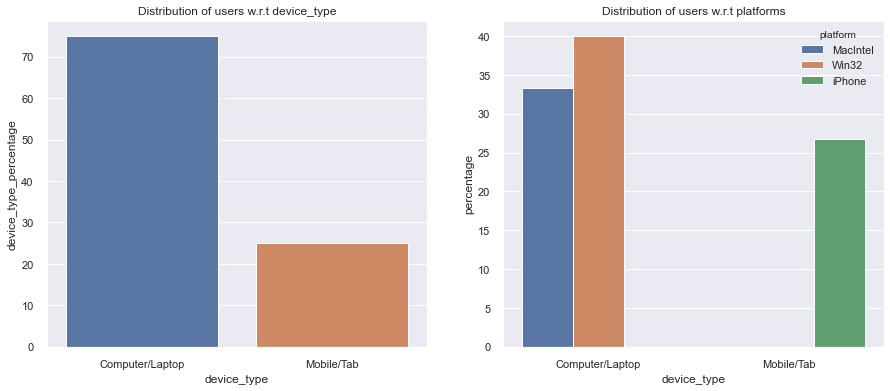

In [44]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='device_type', y='device_type_percentage', data=user_count)
plt.title('Distribution of users w.r.t device_type')
plt.savefig('../images/user_count_device_type.png')

plt.subplot(1,2,2)
sns.barplot(x='device_type', y='percentage', hue='platform', data=user_count)
plt.title('Distribution of users w.r.t platforms')
plt.savefig('../images/user_count_platform.png', bbox_inches='tight')

plt.show()

### True vs false character distribution among various platfroms.

In [26]:
agg_2 = {
    'long_pressed_equivalent' : np.sum,
    'hold_for' : [np.sum, np.mean],
    'pressed_after' : [np.sum, np.mean]
}
char_dist = raw_clean.groupby(['device_type','platform','name']).agg(agg_2).reset_index()
char_dist.columns = ['_'.join(pair) if pair[1] != '' else pair[0] for pair in char_dist.columns]
char_dist.rename(columns={'long_pressed_equivalent_sum':'total_characters_captured'}, inplace=True)
char_dist['total_type_time_mins'] = ((char_dist['hold_for_sum'] + char_dist['pressed_after_sum'])/(1000*60)).round(2)
char_dist

,device_type,platform,name,total_characters_captured,hold_for_sum,hold_for_mean,pressed_after_sum,pressed_after_mean,total_type_time_mins
0,Computer/Laptop,MacIntel,Abdi Mohamud,966,85323,115.457375,114484,154.917456,3.33
1,Computer/Laptop,MacIntel,Kedar,948,74555,86.390498,108090,125.249131,3.04
2,Computer/Laptop,MacIntel,Kunal Sonar,893,83298,108.460938,150183,195.550781,3.89
3,Computer/Laptop,MacIntel,Shalom,1090,108606,104.428846,696226,669.448077,13.41
4,Computer/Laptop,MacIntel,Vikas Ramaneti,1000,73629,77.914286,158935,168.185185,3.88
5,Computer/Laptop,Win32,Goddess,921,98715,111.165541,253684,285.680180,5.87
6,Computer/Laptop,Win32,Halimat,847,75774,95.795196,359257,454.180784,7.25
7,Computer/Laptop,Win32,Pop Eyes,900,98468,154.338558,166831,261.490596,4.42
8,Computer/Laptop,Win32,Sope Ogundipe,882,58373,72.333333,132133,163.733581,3.18
9,Computer/Laptop,Win32,Tarun,1798,144936,95.227332,243954,160.285151,6.48


In [27]:
char_dist.corr()

,total_characters_captured,hold_for_sum,hold_for_mean,pressed_after_sum,pressed_after_mean,total_type_time_mins
total_characters_captured,1.000000,0.754073,0.228581,0.208600,-0.169428,0.389397
hold_for_sum,0.754073,1.000000,0.773495,-0.043819,-0.281168,0.201966
hold_for_mean,0.228581,0.773495,1.000000,-0.239633,-0.274438,-0.045716
pressed_after_sum,0.208600,-0.043819,-0.239633,1.000000,0.908817,0.969602
pressed_after_mean,-0.169428,-0.281168,-0.274438,0.908817,1.000000,0.822013
total_type_time_mins,0.389397,0.201966,-0.045716,0.969602,0.822013,1.000000


In [28]:
type_time_dist = char_dist.groupby('platform').agg({'total_type_time_mins':np.mean}).reset_index().round(2)
type_time_dist

,platform,total_type_time_mins
0,MacIntel,5.51
1,Win32,5.79
2,iPhone,6.11


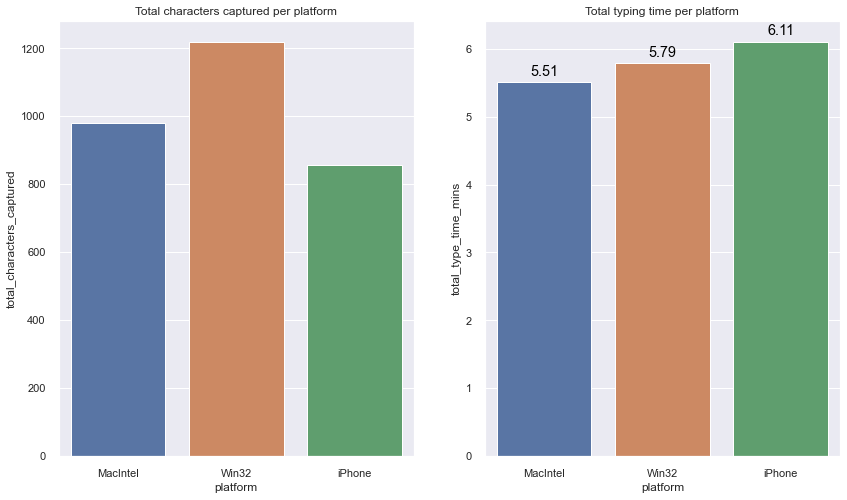

In [45]:
# character captured per platform
# total typing time per device_type
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
sns.barplot(x='platform',y='total_characters_captured', data=char_dist, ci=None)
plt.title('Total characters captured per platform')

plt.subplot(1,2,2)
g = sns.barplot(x='platform',y='total_type_time_mins', data=type_time_dist, ci=None)
for index,row in type_time_dist.iterrows():
    g.text(index,row.total_type_time_mins+0.1, round(row.total_type_time_mins,2), color='black', ha="center", size='large')
plt.title('Total typing time per platform')
plt.savefig('../images/chars_and_time_per_platform.png', bbox_inches='tight')
plt.show()


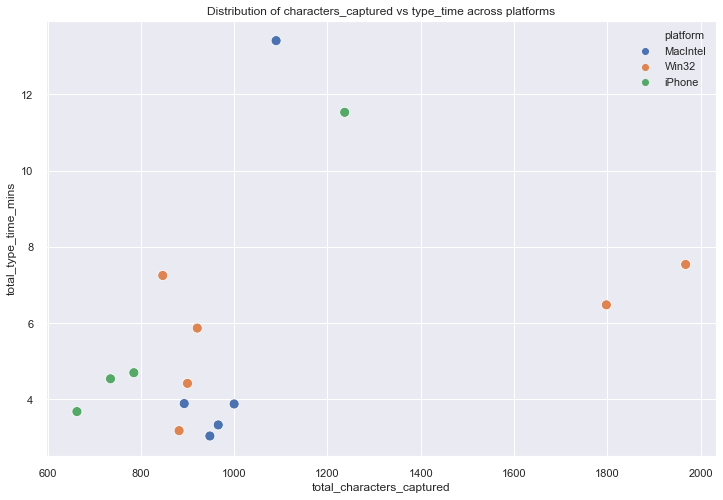

In [46]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='total_characters_captured', y='total_type_time_mins', hue='platform', data=char_dist, s=100)
plt.title('Distribution of characters_captured vs type_time across platforms')
plt.savefig('../images/chars_vs_time.png', bbox_inches='tight')
plt.show()

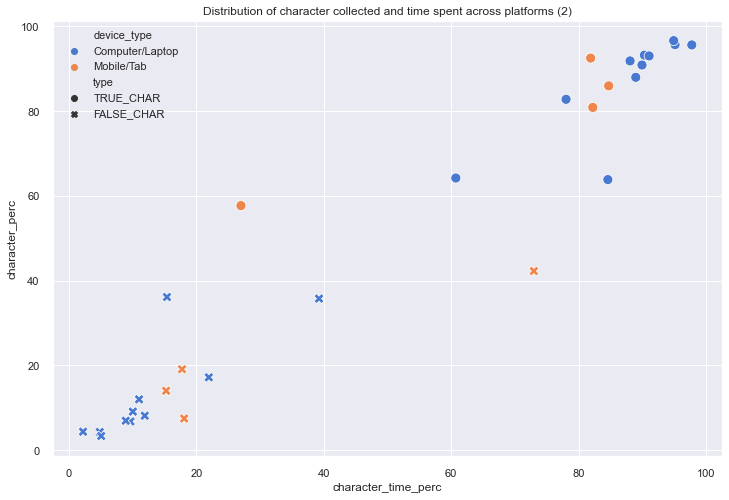

In [47]:

plt.figure(figsize=(12,8))
sns.scatterplot(x='character_time_perc', y='character_perc', hue='device_type', data=user_agg, style='type', palette='muted', s=100)
plt.title('Distribution of character collected and time spent across platforms (2)')
plt.savefig('../images/chars_and_time_per_device_type.png', bbox_inches='tight')
plt.show()

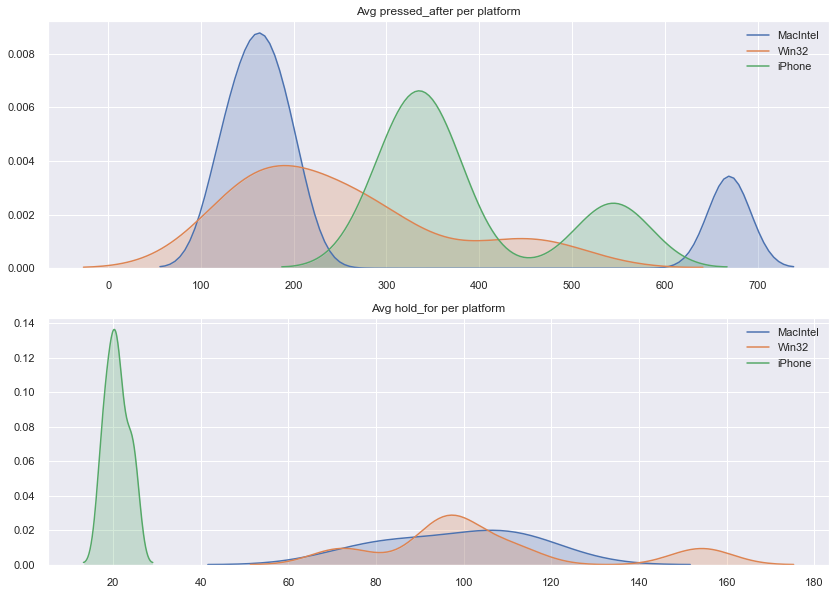

In [48]:
# sns.barplot(x='platform',y='pressed_after_mean', data=char_dist)
# plt.title('Total characters captured per platform')
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
sns.kdeplot(char_dist[char_dist['platform'] =='MacIntel']['pressed_after_mean'], shade=True, label='MacIntel')
sns.kdeplot(char_dist[char_dist['platform'] =='Win32']['pressed_after_mean'], shade=True, label='Win32')
sns.kdeplot(char_dist[char_dist['platform'] =='iPhone']['pressed_after_mean'], shade=True, label='iPhone')

plt.title('Avg pressed_after per platform')

plt.subplot(2,1,2)
sns.kdeplot(char_dist[char_dist['platform'] =='MacIntel']['hold_for_mean'], shade=True, label='MacIntel')
sns.kdeplot(char_dist[char_dist['platform'] =='Win32']['hold_for_mean'], shade=True, label='Win32')
sns.kdeplot(char_dist[char_dist['platform'] =='iPhone']['hold_for_mean'], shade=True, label='iPhone')
plt.title('Avg hold_for per platform')
plt.savefig('../images/avg_pressed_after_hold_for_per_platform.png', bbox_inches='tight')
plt.show()

In [37]:
agg_3 = {
    'long_pressed_equivalent' : [np.sum],
    'hold_for' : [np.sum, np.mean],
    'pressed_after' : [np.sum, np.mean]
}

tf_char_dist = raw_clean.groupby(['device_type','platform','name','false_character']).agg(agg_3).reset_index()
tf_char_dist.columns = ['_'.join(pair) if pair[1] != '' else pair[0] for pair in tf_char_dist.columns]
tf_char_dist['characters_captured_percentage'] = tf_char_dist[['name','long_pressed_equivalent_sum']].apply(lambda x : (x[1]/char_dist.loc[char_dist['name'] == x[0],'total_characters_captured'].values[0]).round(4)*100, axis=1)
tf_char_dist['character_type'] = tf_char_dist['false_character'].map({'f':'correct','t':'incorrect'})
tf_char_dist, _ = encode_to_labels(tf_char_dist, ['name'])

tf_char_dist


,device_type,platform,name,false_character,long_pressed_equivalent_sum,hold_for_sum,hold_for_mean,pressed_after_sum,pressed_after_mean,characters_captured_percentage,character_type
0,Computer/Laptop,MacIntel,0,f,878,77749,117.091867,102013,153.634036,90.89,correct
1,Computer/Laptop,MacIntel,0,t,88,7574,100.986667,12471,166.280000,9.11,incorrect
2,Computer/Laptop,MacIntel,7,f,882,70139,87.455112,96215,119.968828,93.04,correct
3,Computer/Laptop,MacIntel,7,t,66,4416,72.393443,11875,194.672131,6.96,incorrect
4,Computer/Laptop,MacIntel,8,f,863,80496,109.073171,141175,191.294038,96.64,correct
5,Computer/Laptop,MacIntel,8,t,30,2802,93.400000,9008,300.266667,3.36,incorrect
6,Computer/Laptop,MacIntel,10,f,696,69582,105.427273,611381,926.334848,63.85,correct
7,Computer/Laptop,MacIntel,10,t,394,39024,102.694737,84845,223.276316,36.15,incorrect
8,Computer/Laptop,MacIntel,14,f,828,60789,78.235521,120717,155.362934,82.80,correct
9,Computer/Laptop,MacIntel,14,t,172,12840,76.428571,38218,227.488095,17.20,incorrect


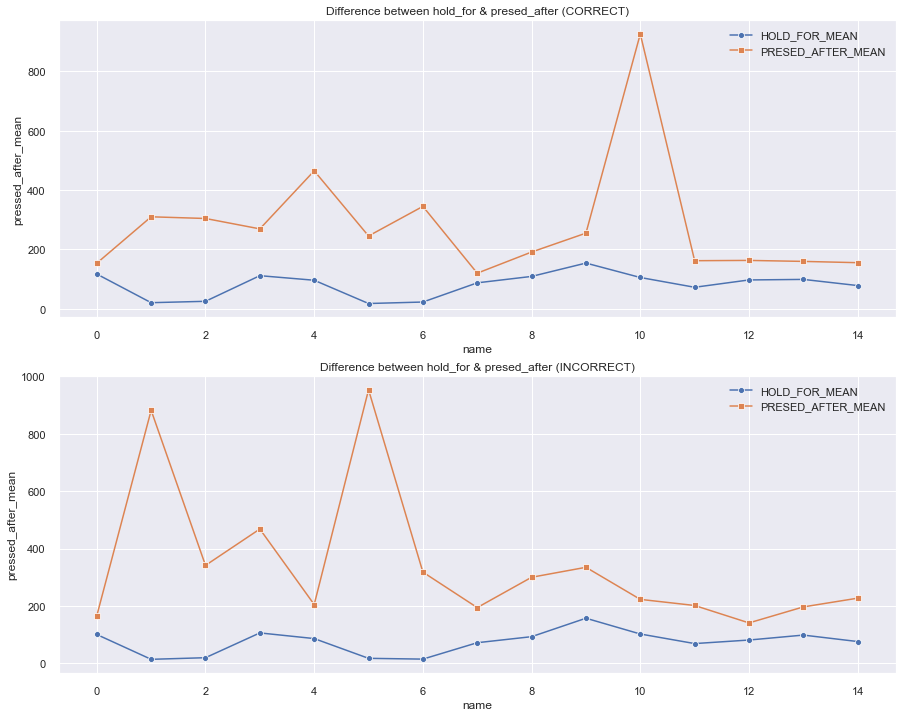

In [42]:
plt.figure(figsize=(15,12))
true_tf_char_dist = tf_char_dist[tf_char_dist['character_type'] == 'correct']
false_tf_char_dist = tf_char_dist[tf_char_dist['character_type'] == 'incorrect']

plt.subplot(2,1,1)
sns.lineplot(x='name',y='hold_for_mean', data=true_tf_char_dist, label='HOLD_FOR_MEAN', marker='o')
sns.lineplot(x='name',y='pressed_after_mean', data=true_tf_char_dist, label='PRESED_AFTER_MEAN', marker='s')
plt.title('Difference between hold_for & presed_after (CORRECT)')

plt.subplot(2,1,2)
sns.lineplot(x='name',y='hold_for_mean', data=false_tf_char_dist, label='HOLD_FOR_MEAN', marker='o')
sns.lineplot(x='name',y='pressed_after_mean', data=false_tf_char_dist, label='PRESED_AFTER_MEAN', marker='s')
plt.title('Difference between hold_for & presed_after (INCORRECT)')
plt.savefig('../images/hold_for_vs_pressed_after_against_false_char.png', bbox_inches='tight')
plt.show()

In [40]:
platform_false_char_agg = raw_clean.groupby(['platform','false_character']).agg({'pressed_after':np.mean, 'hold_for':np.mean, 'long_pressed_equivalent' : np.sum}).reset_index()
platform_false_char_agg['false_character'] = platform_false_char_agg['false_character'].map({'f':'TRUE_CHAR','t':'FALSE_CHAR'})
platform_false_char_agg

,platform,false_character,pressed_after,hold_for,long_pressed_equivalent
0,MacIntel,TRUE_CHAR,294.287558,98.531997,4147
1,MacIntel,FALSE_CHAR,219.071429,93.355742,750
2,Win32,TRUE_CHAR,231.607062,102.277423,6185
3,Win32,FALSE_CHAR,214.035569,97.801829,1131
4,iPhone,TRUE_CHAR,299.573199,21.322618,2599
5,iPhone,FALSE_CHAR,762.430318,17.503667,821


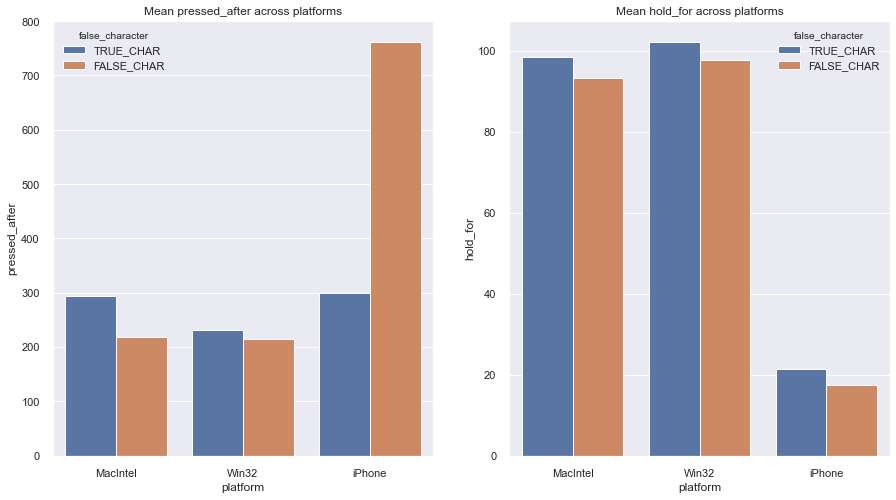

In [49]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.barplot(x='platform',y='pressed_after', hue='false_character', data=platform_false_char_agg)
plt.title('Mean pressed_after across platforms')

plt.subplot(1,2,2)
sns.barplot(x='platform',y='hold_for', hue='false_character', data=platform_false_char_agg)
plt.title('Mean hold_for across platforms')
plt.savefig('../images/avg_pressed_after_hold_for_per_platform_against_false_char.png', bbox_inches='tight')
plt.show()

In [109]:
platform_false_char_agg.groupby('false_character').describe()['pressed_after']

,count,mean,std,min,25%,50%,75%,max
false_character,,,,,,,,
f,3.0,295.154134,4.055815,291.601644,292.944601,294.287558,296.930379,299.573199
t,3.0,424.203809,295.119054,219.071429,255.090555,291.109682,526.770000,762.430318
